In [16]:
import uproot
import vector
import matplotlib.pyplot as plt
import awkward as ak
import math
import numpy as np
import mplhep as hep

# hep.style.use(hep.style.ROOT)
hep.style.use("ATLAS")

# Open the .root file and extract the tau data
# tree = uproot.open('../../Delphes/HepMC2_Outputs/ee_zh_basic.root:Delphes')
# tree = uproot.open('../../Delphes/HepMC2_Outputs/ee_zh_basic_sarah.root:Delphes')
# tree = uproot.open('../../Final_Samples/delphes_ee_zh_mumutautau_sm_PDFs_50000events_230224_Run1.root:Delphes')
# events = tree.arrays(['Event.Weight','Muon_size','Muon.PT','Muon.Eta','Muon.Phi', 'Muon.Charge',
#                      'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.TauTag', 'Jet.Charge', 'Jet.Mass',
#                      'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])

tree = uproot.open(f'../../Final_Samples/sarah_test.root:Delphes')
events = tree.arrays(['Event.Weight','Muon_size','Muon.PT','Muon.Eta','Muon.Phi', 'Muon.Charge',
                 'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.TauTag', 'Jet.Charge', 'Jet.Mass',
                 'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])

# tree = uproot.open('../../Final_Samples/SM_100000_300424_Run1.root:Delphes')
# events = tree.arrays(['Event.Weight','Muon_size','Muon.PT','Muon.Eta','Muon.Phi', 'Muon.Charge',
#                      'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.TauTag', 'Jet.Charge', 'Jet.Mass',
#                      'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])


# create filters to select the events of interest
# ditau_mask = (events['Jet_size'] == 2) & (events['Muon_size'] == 2)  & (ak.sum(events['Jet.TauTag'], axis=1) == 2)

#create the ditau system
jets = vector.zip({'pt':events['Jet.PT'],'eta':events['Jet.Eta'],
                   'phi':events['Jet.Phi'],'mass':events['Jet.Mass'],
                   'charge':events['Jet.Charge'],
                   'tautag':events['Jet.TauTag']})

all_muons = vector.zip({'pt':events['Muon.PT'],'eta':events['Muon.Eta'],
                   'phi':events['Muon.Phi'],'mass':0.10566})

# # create filters to select the events of interest
# ditau = taus[ditau_mask]
# dimuon = muons[ditau_mask]

In [17]:
print(len(events))

743487


In [3]:
def histogram(data, weights, bins, colour, range, plot = True, label = None):
    """Unfortunately, plt.hist does not support error bars, so we have to use plt.errorbar
    using manual inputs from np.histogram"""
    bin_width = (range[1]-range[0])/bins
    weights = weights/bin_width
    nphisto = np.histogram(data, bins=bins, range = range, weights=[i[0] for i in weights])
    err = np.histogram(data, bins=bins, range = range, weights=[i[0]**2 for i in weights])
    if plot:
        plt.hist(data, bins=bins, histtype='step', range = range, color=colour, weights=weights, label = label)
        plt.errorbar(nphisto[1][:-1]+((range[1]-range[0])/(2*bins)), nphisto[0], yerr=np.sqrt(err[0]), fmt=',', color=colour)
        plt.xlim(range)
        plt.axhline(0, color = 'k', linestyle='--',linewidth = 0.5)
    return nphisto, np.sqrt(err[0])

In [4]:
"""Function to filter jet into taus only since jet size is no longer fixed to 2"""
def filter_taus(jet):
    tau_mask = []   # overall mask for all events
    for i in jet:
        tagged = [] # sub-mask for each event
        for t in i:
            tagged.append(t.tautag == 1)
        tau_mask.append(tagged)
    taus = jet[tau_mask]
    return taus

In [18]:
initial_length = len(events)
ditau_mask = (events['Jet_size'] >= 2) & (events['Muon_size'] == 2) & (ak.sum(events['Jet.TauTag'], axis=1) == 2)
preselect = sum(ditau_mask)
ditau_mask = ditau_mask & (ak.sum(events['Muon.Charge'], axis=1) == 0)
muon_charge = sum(ditau_mask)
# I am not sure of an elegant way to loop over to check the tau charges, so I will do it more explicitly
tau_charge_mask = []
for i in events:
    tau_charge = 0
    for j,e in enumerate(i['Jet.Charge']):
        if i['Jet.TauTag'][j] == 1:
            tau_charge += e
    # we already filter out for 2 taus elsewhere
    # so whilst this accepts invalid events (e.g. no taus)
    # we are free to just sum the charges as other filters combine with this
    # meaning we are summing over the 2 tau charges overall
    tau_charge_mask.append(tau_charge == 0)
ditau_mask = ditau_mask & tau_charge_mask
tau_charge = sum(ditau_mask)
print(f"Initial: {initial_length}, Preselect: {preselect}, Muon Charge: {muon_charge}, Tau Charge: {tau_charge}")
preselect_perc = (preselect/initial_length) * 100
muon_charge_perc = (muon_charge/preselect) * 100
tau_charge_perc = (tau_charge/preselect) * 100
print(f"Preselect Efficiency: {preselect_perc:.3f}%")
print(f"Muon Charge Efficiency: {muon_charge_perc:.2f}%")
print(f"Tau Charge Efficiency: {tau_charge_perc:.2f}%")

Initial: 743487, Preselect: 102206, Muon Charge: 101763, Tau Charge: 99327
Preselect Efficiency: 13.747%
Muon Charge Efficiency: 99.57%
Tau Charge Efficiency: 97.18%


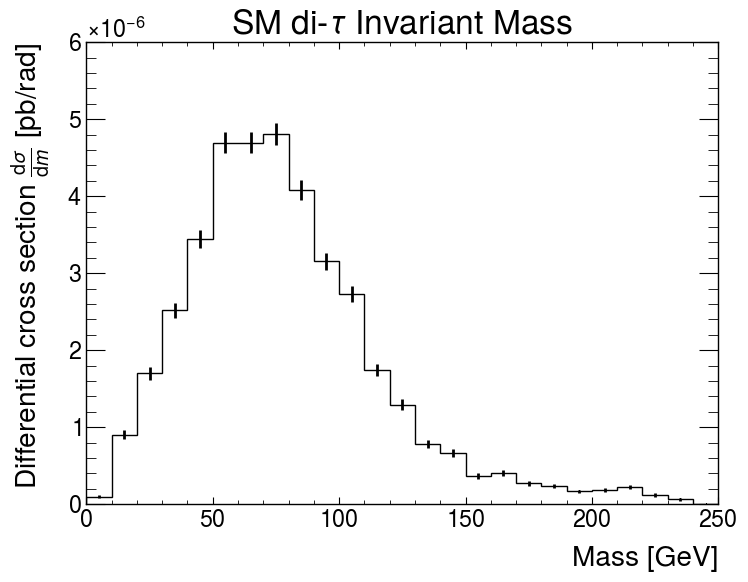

In [33]:
"""Importantly, now we need to only pass the two taus into the ditau_inv_mass function, since the jet size is not fixed"""
taus = filter_taus(jets[ditau_mask])
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass, events['Event.Weight'][ditau_mask]/len(events), 25, 'k', (0, 250), plot = True)
plt.title(r"SM di-$\tau$ Invariant Mass")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$ [pb/rad]')
plt.savefig("ditau_mass_uncut.png")

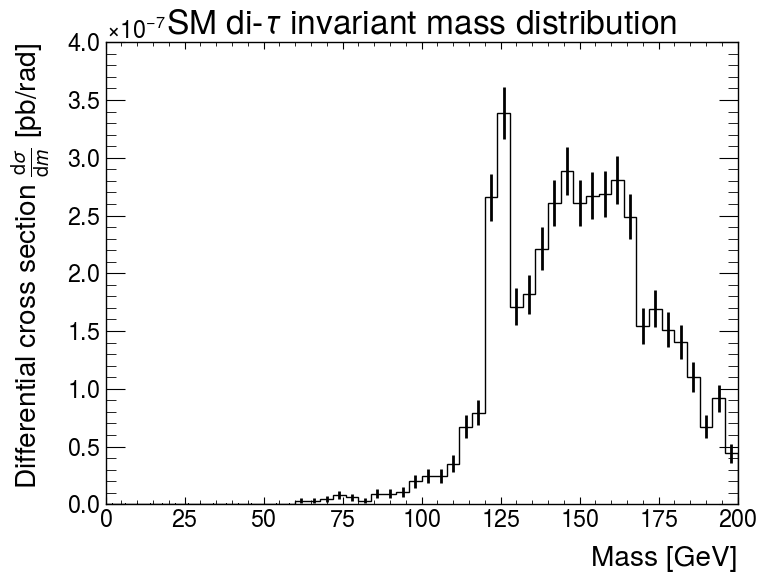

In [27]:
"""Attempting to reconstruct the Higgs mass peak from the ditau system properly
using the missing energy"""
met = vector.zip({'pt':events['MissingET.MET'],'eta':events['MissingET.Eta'],
                   'phi':events['MissingET.Phi'],'mass':0})
met = met[ditau_mask]
if len(met) != len(taus):
    met = met[valid_taus]
    print("Cuts added")
r1 = abs(((met.py*taus[:,0].px) - (met.px*taus[:,0].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
r2 = abs(((met.py*taus[:,1].px) - (met.px*taus[:,1].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
f1 = 1/(1+r1)
f2 = 1/(1+r2)
scales = [math.sqrt(i[0]*j[0]) for i,j in zip(f1,f2)]
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass/scales, events['Event.Weight'][ditau_mask]/len(events), 50, 'k', (0, 200), plot = True)
plt.xlabel('Mass [GeV]')
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$ [pb/rad]')
plt.title(r'SM di-$\tau$ invariant mass distribution')
plt.savefig("ditau_mass_scaled_uncut.png")

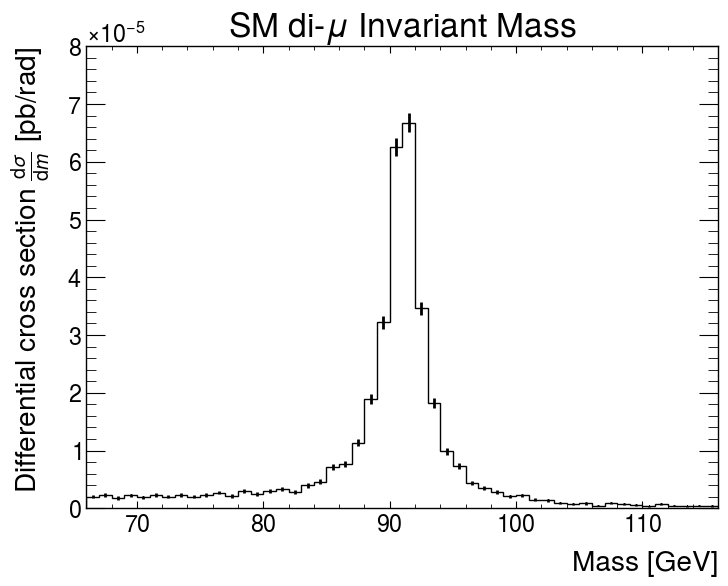

In [7]:
dimuon = all_muons[ditau_mask]
dimuon_mass = (dimuon[:,0]+dimuon[:,1]).mass
histogram(dimuon_mass, events['Event.Weight'][ditau_mask]/len(events), 50, 'k', (66, 116), plot = True)
plt.title(r"SM di-$\mu$ Invariant Mass")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'Differential cross section $\frac{\mathrm{d}\sigma}{\mathrm{d}m}$ [pb/rad]')
plt.savefig("dimuon_mass_uncut.png")

In [24]:
"""Apply some 4 vector cuts to tau and muon candidates"""
taus = filter_taus(jets[ditau_mask])
print(len(ditau_mask))
tau_cuts = []
muons = all_muons[ditau_mask]
zcandidate = muons[:,0]+muons[:,1]
recoilmass = [math.sqrt(240*240 + i.mass*i.mass - 480*i.E) for i in zcandidate]
ditau_mass = (taus[:,0]+taus[:,1]).mass
for n,i in enumerate(taus):
    # ditau_mass = (i[0]+i[1]).mass
    # tau_cuts.append(ak.any(i.pt < 10) or (ditau_mass > 125) or (ditau_mass < 25))
    # tau_cuts.append(ak.any(i.pt < 10))
    cut = False
    # print(muons[n])
    "Tau minimum pt cut"
    if ak.any(i.pt < 10):
        cut = True
    "Muon minimum pt cut"
    if ak.any(muons[n].pt < 10):
        cut = True
    "Z candidate pt cut"
    if zcandidate[n].pt < 30 or zcandidate[n].pt > 55:
        cut = True
    "Dimuon mass cut (for which we can use the z candidate 4 vector as it is the sum of the two muons)"
    if abs(zcandidate[n].mass - 91.2) > 10:
        cut = True
    "Recoil mass cut"
    if abs(recoilmass[n] - 125) > 3:
        cut = True
    "Ditau mass cut"
    if ditau_mass[n] > 125 or ditau_mass[n] < 25:
        cut = True
    # "Ditau mass cut"
    # if ditau_mass[n] > 135 or ditau_mass[n] < 115:
    #     cut = True
    tau_cuts.append(cut)
valid_events = [not i for i in tau_cuts]
taus = taus[valid_events]
muons = muons[valid_events]

ditau_events = events[ditau_mask]
ditau_events = ditau_events[valid_events]
weights = ditau_events['Event.Weight'] / len(events)

print(len(taus), len(taus) / preselect * 100)

743487
1503 1.470559458348825


1503


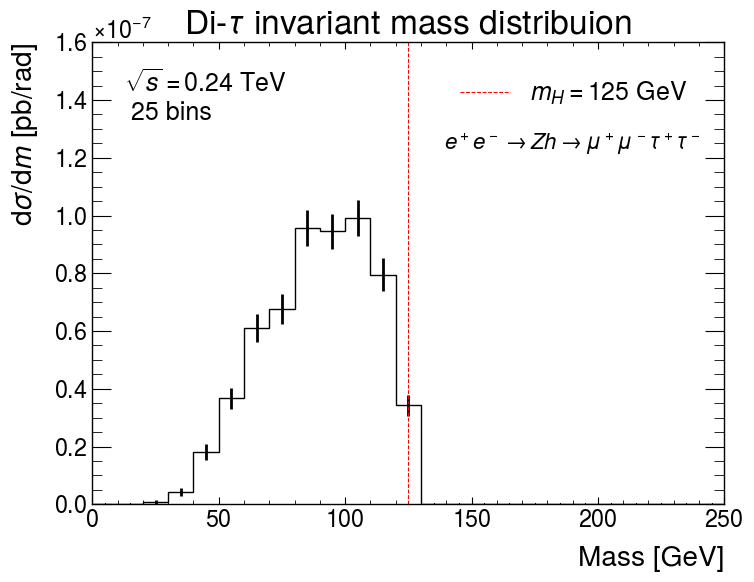

In [23]:
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass, weights, 25, 'k', (0, 250), plot = True)
plt.title(r"Di-$\tau$ invariant mass distribuion")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'$\mathrm{d}\sigma / \mathrm{d}m$ [pb/rad]')
plt.ylim(0, 1.6e-7)
plt.axvline(125, color = 'r', linestyle='--',linewidth = 0.75, label = r'$m_H = 125$ GeV')
plt.text(0.2, 0.8, r'$\sqrt{s} = 0.24$ TeV' + '\n 25 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.6, 0.75, r'$e^+ e^- \rightarrow Z h \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=16, transform=plt.gcf().transFigure)
plt.legend(fontsize = 18)
plt.savefig("ditau_mass_cut.png")
plt.savefig("ditau_mass_cut.pdf")
print(len(ditau_mass))

Cuts added
1503


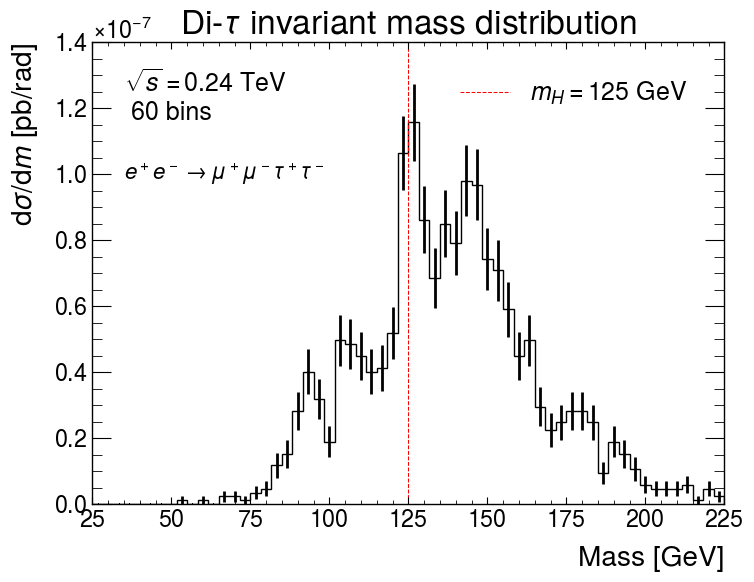

In [51]:
met = vector.zip({'pt':events['MissingET.MET'],'eta':events['MissingET.Eta'],
                   'phi':events['MissingET.Phi'],'mass':0})
met = met[ditau_mask]
if len(met) != len(taus):
    met = met[valid_events]
    print("Cuts added")
print(len(ditau_mass))
r1 = abs(((met.py*taus[:,0].px) - (met.px*taus[:,0].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
r2 = abs(((met.py*taus[:,1].px) - (met.px*taus[:,1].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
f1 = 1/(1+r1)
f2 = 1/(1+r2)
scales = [math.sqrt(i[0]*j[0]) for i,j in zip(f1,f2)]
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass/scales, weights, 60, 'k', (25, 225), plot = True, label = None)
plt.axvline(125, color = 'r', linestyle='--',linewidth = 0.75, label = r'$m_H = 125$ GeV')
plt.xlabel('Mass [GeV]')
plt.ylabel(r'$\mathrm{d}\sigma / \mathrm{d}m$ [pb/rad]')
plt.title(r'Di-$\tau$ invariant mass distribution')
plt.text(0.2, 0.8, r'$\sqrt{s} = 0.24$ TeV' + '\n 60 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.2, 0.7, r'$e^+ e^- \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=16, transform=plt.gcf().transFigure)
plt.legend(fontsize = 18, loc = 'upper right')
plt.savefig("ditau_mass_scaled_cut.png")
plt.savefig("ditau_mass_scaled_cut.pdf")

1503


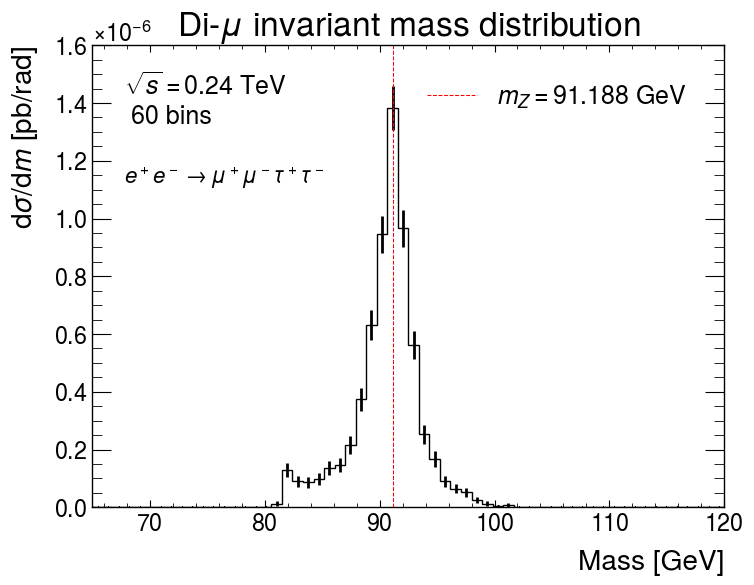

In [37]:
dimuon_mass = (muons[:,0]+muons[:,1]).mass
histogram(dimuon_mass, weights, 60, 'k', (65, 120), plot = True)
plt.title(r"Di-$\mu$ invariant mass distribution")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'$\mathrm{d}\sigma / \mathrm{d}m$ [pb/rad]')
plt.axvline(91.188, color = 'r', linestyle='--',linewidth = 0.75, label = r'$m_Z = 91.188$ GeV')
plt.text(0.2, 0.8, r'$\sqrt{s} = 0.24$ TeV' + '\n 60 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.2, 0.7, r'$e^+ e^- \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=16, transform=plt.gcf().transFigure)
plt.legend(fontsize = 18, loc = 'upper right')
plt.savefig("dimuon_mass_cut.png")
plt.savefig("dimuon_mass_cut.pdf")
print(len(dimuon_mass))

In [14]:
sm_run = 'test'

'Each element in the list is a numpy array of the data for one sample run'
sm_tau_data = []
sm_muon_data = []
sm_weights = []

# Change commented out code if testing with different data

for i in range(1,2):
    sm_tau_data.append(np.load(f'sm_data/{sm_run}/sm_taus_run_{i}.npy'))
    sm_muon_data.append(np.load(f'sm_data/{sm_run}/sm_muons_run_{i}.npy'))
    sm_weights.append(np.load(f'sm_data/{sm_run}/sm_weights_run_{i}.npy'))

sm_taus = []
for j in sm_tau_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    tautag = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]]) # NOTE these are flipped with eta!
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        charge.append([i[0][4], i[1][4]])
        tautag.append([i[0][5], i[1][5]])
    taus = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass,'charge':charge,'tautag':tautag})
    sm_taus.append(taus)

sm_muons = []
for j in sm_muon_data:
    pt = []
    eta = []
    phi = []
    mass = []
    charge = []
    for i in j:
        pt.append([i[0][0], i[1][0]])
        eta.append([i[0][2], i[1][2]])
        phi.append([i[0][1], i[1][1]])
        mass.append([i[0][3], i[1][3]])
        try:
            charge.append([i[0][4], i[1][4]])
        except:
            pass
    if len(charge) > 0:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass, 'charge':charge})
    else:
        muons = vector.zip({'pt':pt,'eta':eta,'phi':phi,'mass':mass})
    sm_muons.append(muons)

taus = sm_taus[0]
muons = sm_muons[0]
weights = sm_weights[0]

1503


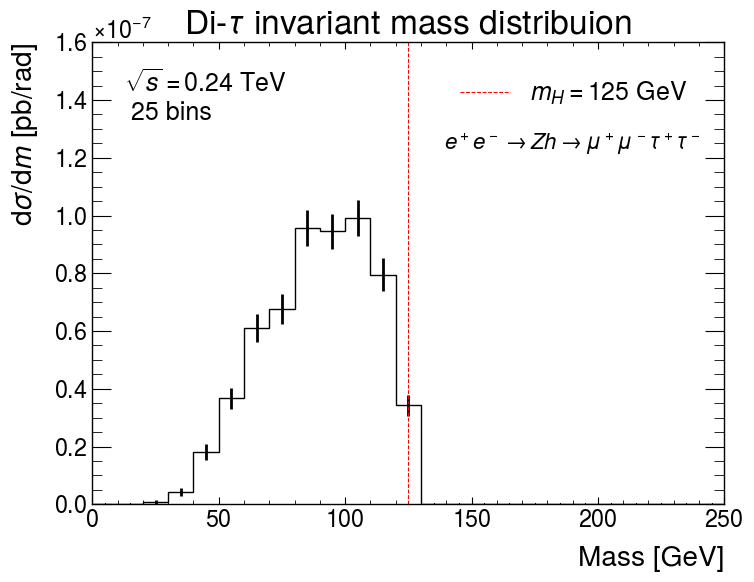

In [15]:
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass, weights, 25, 'k', (0, 250), plot = True)
plt.title(r"Di-$\tau$ invariant mass distribuion")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'$\mathrm{d}\sigma / \mathrm{d}m$ [pb/rad]')
plt.ylim(0, 1.6e-7)
plt.axvline(125, color = 'r', linestyle='--',linewidth = 0.75, label = r'$m_H = 125$ GeV')
plt.text(0.2, 0.8, r'$\sqrt{s} = 0.24$ TeV' + '\n 25 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.6, 0.75, r'$e^+ e^- \rightarrow Z h \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=16, transform=plt.gcf().transFigure)
plt.legend(fontsize = 18)
plt.savefig("ditau_mass_cut.png")
plt.savefig("ditau_mass_cut.pdf")
print(len(ditau_mass))

In [16]:
met = vector.zip({'pt':events['MissingET.MET'],'eta':events['MissingET.Eta'],
                   'phi':events['MissingET.Phi'],'mass':0})
met = met[ditau_mask]
if len(met) != len(taus):
    met = met[valid_events]
    print("Cuts added")
print(len(ditau_mass))
r1 = abs(((met.py*taus[:,0].px) - (met.px*taus[:,0].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
r2 = abs(((met.py*taus[:,1].px) - (met.px*taus[:,1].py))/((taus[:,0].py*taus[:,1].px) - (taus[:,0].px*taus[:,1].py)))
f1 = 1/(1+r1)
f2 = 1/(1+r2)
scales = [math.sqrt(i[0]*j[0]) for i,j in zip(f1,f2)]
ditau_mass = (taus[:,0]+taus[:,1]).mass
histogram(ditau_mass/scales, weights, 50, 'k', (25, 225), plot = True, label = None)
plt.axvline(125, color = 'r', linestyle='--',linewidth = 0.75, label = r'$m_H = 125$ GeV')
plt.xlabel('Mass [GeV]')
plt.ylabel(r'$\mathrm{d}\sigma / \mathrm{d}m$ [pb/rad]')
plt.title(r'Di-$\tau$ invariant mass distribution')
plt.text(0.2, 0.8, r'$\sqrt{s} = 0.24$ TeV' + '\n 50 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.2, 0.7, r'$e^+ e^- \rightarrow Z h \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=16, transform=plt.gcf().transFigure)
plt.legend(fontsize = 18, loc = 'upper right')
plt.savefig("ditau_mass_scaled_cut.png")
plt.savefig("ditau_mass_scaled_cut.pdf")

NameError: name 'ditau_mask' is not defined

1503


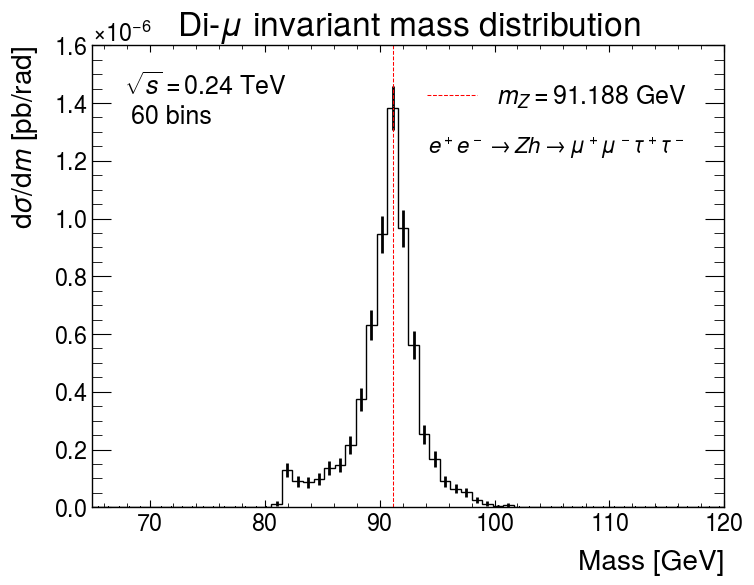

In [17]:
dimuon_mass = (muons[:,0]+muons[:,1]).mass
histogram(dimuon_mass, weights, 60, 'k', (65, 120), plot = True)
plt.title(r"Di-$\mu$ invariant mass distribution")
plt.xlabel(r"Mass [GeV]")
plt.ylabel(r'$\mathrm{d}\sigma / \mathrm{d}m$ [pb/rad]')
plt.axvline(91.188, color = 'r', linestyle='--',linewidth = 0.75, label = r'$m_Z = 91.188$ GeV')
plt.text(0.2, 0.8, r'$\sqrt{s} = 0.24$ TeV' + '\n 60 bins', fontsize=18, transform=plt.gcf().transFigure)
plt.text(0.58, 0.75, r'$e^+ e^- \rightarrow Z h \rightarrow \mu^+ \mu^- \tau^+ \tau^-$', fontsize=16, transform=plt.gcf().transFigure)
plt.legend(fontsize = 18, loc = 'upper right')
plt.savefig("dimuon_mass_cut.png")
plt.savefig("dimuon_mass_cut.pdf")
print(len(dimuon_mass))